### SCC5830 - Image Processing - Final Project
2019 - 1st semester
#### Gabriel Gazetta de Araujo.  nº USP 10877911


## Image restoration: Periodic noise removal



### Abstract:

Images with patterned noises can be difficult to process or even to visualize. These patterns are high-frequency noises that scatter throughout the images. With that said, this final project aims to design a code capable of removing periodic noise (pattern) from images. In order to remove those patterns, it is necessary to convert the images to the frequency domain through Fourier Transform in order to visualize and cancel out those high-frequency regions with filters that cancels the specific high-frequency areas in the image, resulting in an image with no pattern and little to no blur.

At first, the main step is to import all the libraries needed for this project. And then, defining a function to read an image.

In [151]:
import numpy as np
from scipy.fftpack import fftn, ifftn, fftshift, ifft2
import matplotlib.pyplot as plt
import imageio
from PIL import Image

In [152]:
def get_img():
    filename = str(input("Image address ")).rstrip()
    img = imageio.imread(filename)
    return img

Image address lena_corrupted.png


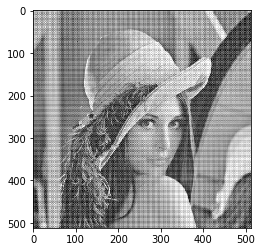

In [153]:
img = get_img()
plt.imshow(img, cmap = "gray")

As can be seen, this image has a high-frequency noise, presented by the gingham pattern throughout the image.
Our goal here is to successfully remove this pattern without losing too much information from the image itself.
Visualizing this image in the Fourier Spectra can help to better understand what has to be done and how.

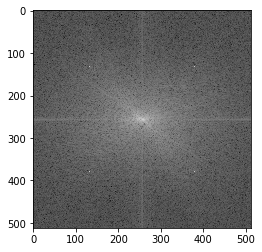

In [154]:
fimg = fftn(img)
fimg = (np.log(1+np.abs(fftshift(fimg))))
plt.imshow(np.real(fimg), cmap = "gray")


Analyzing the Fourier Spectra, it can be said that some of the information available in the spectra can be seen on the image itself, such as a diagonal line corresponding to Lena's hat. However, four small dots can be found in each quadrant, these high-frequency points are related to the patterns disturbing the image. With that said, removing these dots will most likely remove the noise on the image as well. Before that, let's define a function that converts images to the frequency domain while doubles it in size.

In [155]:
def spatialtofreq(img):
    m, n = img.shape
    diff = abs(m-n)
    new_m, new_n = m, n
    if(m > n):
        new_n = n+diff
    else:
        new_m = m+diff  
    nimg = np.zeros((new_m,new_n))
    nimg[:m,:n] = img
    ftimg = fftn(nimg) 
    ftimg = fftshift(ftimg)
    return ftimg

The idea here is to create a function that filters out the minimum necessary area to remove the patterns on the image. Because of that, a band-stop filter, that creates a band on a specific area and removes high frequencies on it is the advised approach to this project.
With that said, creating those filters to apply to the image is necessary. In this project, the approach is to use Gaussian and Butterworth Band-Reject filters and then, apply a Notch filter to filter out the smallest area possible in order not to lose too much information on the picture. 

In [158]:
def butterworth(euclideand, cutofffrequency, bandwidth, order):
            result = 1/(1+((euclideand*bandwidth)/((euclideand**2)-(cutofffrequency**2)))**(2.*order))
            return result

In [159]:
def gaussian(euclideand, cutofffrequency, bandwidth):
        result = 1-np.exp(-((euclideand**2-cutofffrequency**2)/(euclideand*bandwidth))**2)
        return result

In [160]:
def in_circle(x,y,i,j,r):
    dist_from_center = np.sqrt(np.square(i-x) + np.square(j-y))
    return dist_from_center <= r


def notch(filter, array, r):
    for line in array:
        x = line[0]
        y = line[1]
        for i in range(x-r,x+r+1):
            for j in range(y-r,y+r+1):
                if in_circle(i,j,x,y,r):
                    try:
                        if i>=0 or j>=0:
                            filter[i,j] = 1
                        else:
                            pass
                    except:
                        pass
    return filter

After defining the mask, the next step is to create the filter itself. The outcome will depend on the type selected.

In [161]:
def Filter(img):
    type = (input("Insert type of filter: "))
    m,n = np.shape(img)
    imgout = np.zeros((m,n))
    cx = np.floor(m/2)+1
    cy = np.floor(n/2)+1
    if(type == "notch"):
                notches = np.array(eval(input("Insert array with coordinates ")))
                r = int(input("Insert notch radius "))
                imgout = notch(imgout, notches, r)
                imgout = 1 - imgout
    elif type == "butterworth" or "gaussian":
        bandwidth = int(input("Bandwidth: "))
        cutofffrequency = int(input("Cut-off Frequency: "))
        order = int(input("Order: "))
        for x in range(m):
            for y in range(n):
                euclideand = np.sqrt((x-cx)**2+(y-cy)**2)
                if(type == "butterworth"):
                    imgout[x,y] = butterworth(euclideand, cutofffrequency, bandwidth, order)
                elif(type == "gaussian"):
                    imgout[x,y] = gaussian(euclideand, cutofffrequency, bandwidth)
    return imgout

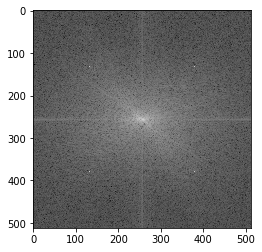

In [162]:
ftimg = spatialtofreq(img)
ftimg_plot = np.log(1+np.abs(ftimg))
plt.imshow(ftimg_plot, cmap = "gray")

With that defined, let's visualize the filter itself on top of the image.
For this, let's choose the butterworth filter, with bandidth 60, cut-off frequency 160 and order 4.

Insert type of filter: butterworth
Bandwidth: 60
Cut-off Frequency: 160
Order: 4


/home/gabriel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


<Figure size 432x288 with 0 Axes>

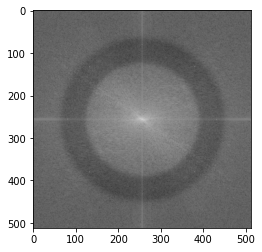

<Figure size 432x288 with 0 Axes>

In [163]:
res_band = Filter(img)
plt.imshow(res_band, cmap=plt.cm.gray, interpolation='nearest')
plt.imshow(ftimg_plot, alpha=.9, cmap = "gray", interpolation='bilinear')
plt.figure()

Before applying the filter to the image, a function to convert the image from the frequency domain back to the spatial domain is necessary. This function also crops the image back to its original shape.

In [164]:
def freqtospatial(fimg, img):
    m, n = img.shape
    image = np.abs(ifft2(fimg))
    image = image.astype(np.uint8)
    crop_img = image[0:m, 0:n]
    return(crop_img)

After so, let's finally apply the filter to the image and convert it back to space domain to visualize it.

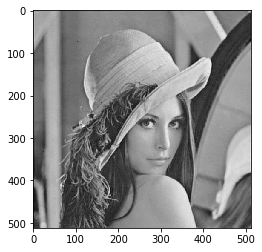

In [165]:
resulting_img_band = freqtospatial(np.multiply(ftimg,res_band),img)
plt.imshow(resulting_img_band, cmap = "gray")

As can be seen above, the image now has no pattern at all, however, since the band-stop filter removed, according to its name, a band around the frequency domain, some of the information is lost. A notch filter would carve out the specific regions where the high-frequency patterns are, without compromising the image quality, sharpness, or definition. Let's use it and compare to the image above.


For Lena with notch filter, try the following coordinates: [[129,129],[129,380],[380,129],[380,380],[80,256],[430,256],[256,80],[256,430]]

Insert type of filter: notch
Insert array with coordinates [[129,129],[129,380],[380,129],[380,380],[80,256],[430,256],[256,80],[256,430]]
Insert notch radius 10


<Figure size 432x288 with 0 Axes>

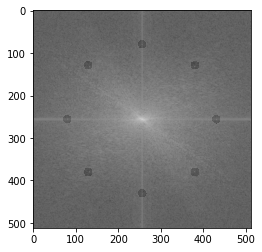

<Figure size 432x288 with 0 Axes>

In [166]:
res_notch = Filter(img)
plt.imshow(res_notch, cmap=plt.cm.gray, interpolation='nearest')
plt.imshow(ftimg_plot, alpha=.9, cmap = "gray", interpolation='bilinear')
plt.figure()

The figure above shows the filter on top of the image on frequency domain, covering the exact spots that are responsible for the noise.

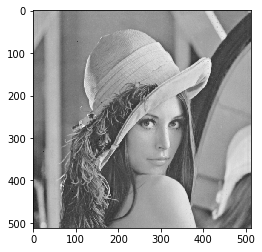

In [167]:
resulting_img_notch = freqtospatial(np.multiply(ftimg,res_notch),img)
plt.imshow(resulting_img_notch, cmap = "gray")

Finally, let's compare the two resulting images:

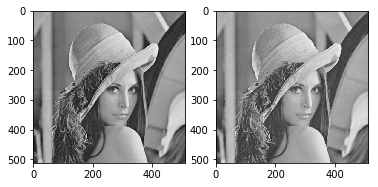

In [168]:
plt.subplot(121)
plt.imshow(resulting_img_band, cmap = "gray")
plt.subplot(122)
plt.imshow(resulting_img_notch, cmap = "gray")

Although the images look similar, it can be noticed that the image on the right looks sharper and more detailed than the left one. That is due to the fact that a notch filter carves out as little as possible of the image, resulting in little to no loss in image information.